<a href="https://colab.research.google.com/github/Lis198407/goit-ds-hw07/blob/main/lytvinenko_ihor_OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [ ]:
  csv_file = "/content/drive/MyDrive/Colab Notebooks/bikes_rent.csv"
  df = pd.read_csv(csv_file)
  df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

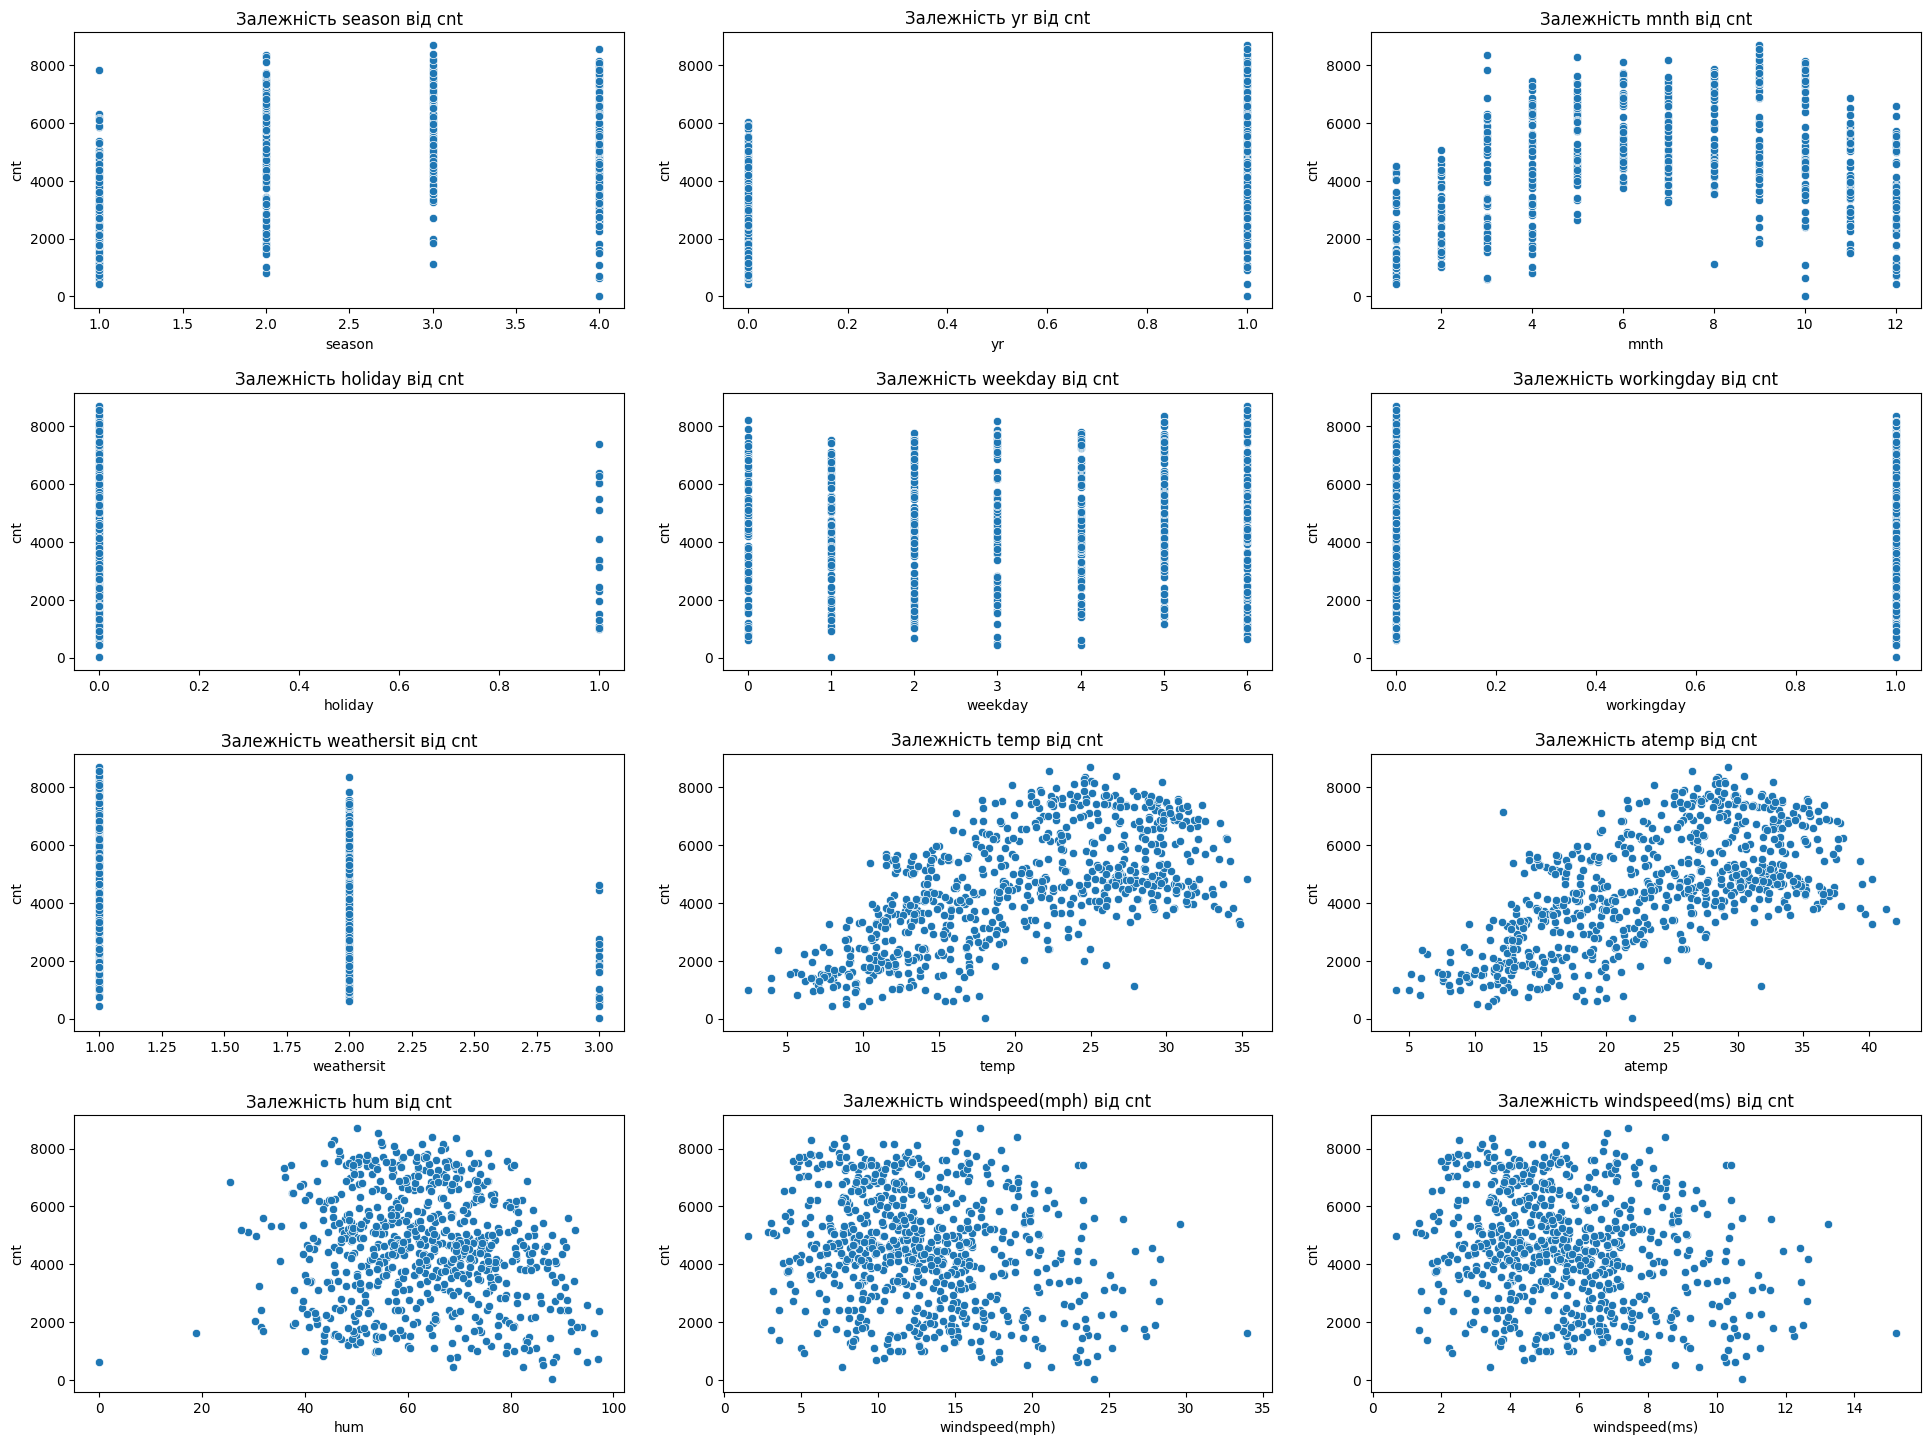

In [ ]:
import seaborn as sns

attributes = df.columns
fig, sub_plot = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.tight_layout(pad=4.0)

for i, attribute in enumerate(attributes):
    row, col = divmod(i, 3)
    if attribute == 'cnt':
        break
    sns.scatterplot(ax=sub_plot[row, col], x=df[attribute], y=df['cnt'])
    sub_plot[row, col].set_title(f'Залежність {attribute} від cnt')
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

**Відповідь:**
1. з березня по жовтень кількість оренд вище, тобто є сезоність в залежності від місяця
2. залежить від temp, atemp

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [ ]:
# версія через corr
# pd.options.display.float_format = '{:,.2f}'.format
# df.corr().sort_values(by='cnt',ascending=False)['cnt']

# версія через corrwith
X = df
X = X.drop('cnt',axis=1)
y=df['cnt']
X.corrwith(y).sort_values(ascending=False)

atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [ ]:
# попарні кореляції
attributes = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
for attribute in attributes:
    print(f"corelation beetwen cnt and {attribute}:  {y.corr(other = X[attribute])}")

# всі корреляції
print ("\n all corelations\n")
df.corr()

corelation beetwen cnt and temp:  0.6274940090334922
corelation beetwen cnt and atemp:  0.6310656998491815
corelation beetwen cnt and hum:  -0.1006585621371552
corelation beetwen cnt and windspeed(mph):  -0.23454499742167012
corelation beetwen cnt and windspeed(ms):  -0.23454499742168924

 all corelations



,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [ ]:
X.mean()

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [ ]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [ ]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [ ]:
model_sklearn = LinearRegression()
model_sklearn.fit(X, y)
coefficients = model_sklearn.coef_

formatted_coefficients = [f'{coef:.2f}' for coef in coefficients]
print("Coefficients:", formatted_coefficients)
formatted_intercept = f'{model_sklearn.intercept_:.2f}'
print("Intercept:", formatted_intercept)

Coefficients: ['570.86', '1021.97', '-141.30', '-86.76', '137.23', '56.39', '-330.23', '367.48', '585.55', '-145.61', '12457138390688.88', '-12457138390887.35']
Intercept: 4504.35


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X, y)

coef_lasso = lasso_reg.coef_
intercept_lasso = lasso_reg.intercept_

f_coef_lasso = [f'{coef:.2f}' for coef in coef_lasso]
f_intercept_lasso = f'{intercept_lasso:.2f}'

print("Lasso regularization coeff:", f_coef_lasso)
print("Lasso Intercept:", f_intercept_lasso)


Lasso regularization coeff: ['560.24', '1019.46', '-128.73', '-86.15', '137.35', '55.21', '-332.37', '376.36', '576.53', '-144.13', '-197.14', '-0.00']
Lasso Intercept: 4504.35


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [ ]:
from sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X, y)

coef_ridge = ridge_reg.coef_
intercept_ridge = ridge_reg.intercept_

f_coef_ridge = [f'{coef:.2f}' for coef in coef_ridge]
f_intercept_ridge = f'{intercept_ridge:.2f}'

print("Ridge regularization coeff:", f_coef_ridge)
print("Ridge Intercept:", f_intercept_ridge)

Ridge regularization coeff: ['563.06', '1018.95', '-131.87', '-86.75', '138.01', '55.90', '-332.35', '386.46', '566.35', '-145.07', '-99.26', '-99.26']
Ridge Intercept: 4504.35


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [36]:
    import numpy as np
    alphas = np.arange(1, 500, 50)
    np.set_printoptions(linewidth=200,suppress=True,formatter={'float_kind':'{:0.1f}'.format})

    coefs_lasso = []
    coefs_ridge = []

    for alpha_ in alphas:
        lasso_reg = Lasso(alpha=alpha_)
        lasso_reg.fit(X, y)
        coefs_lasso.append(lasso_reg.coef_)

        ridge_reg = Ridge(alpha=alpha_)
        ridge_reg.fit(X, y)
        coefs_ridge.append(ridge_reg.coef_)

    coefs_lasso = np.array(coefs_lasso)
    coefs_ridge = np.array(coefs_ridge)
    print(f"lasso array: \n {coefs_lasso}")
    print(f"ridge array: \n {coefs_ridge}")

lasso array: 
 [[560.2 1019.5 -128.7 -86.2 137.3 55.2 -332.4 376.4 576.5 -144.1 -197.1 -0.0]
 [411.0 977.0 -0.0 -53.4 91.9 17.5 -318.1 322.8 610.0 -91.1 -145.1 -0.0]
 [370.1 935.9 0.0 -12.2 48.9 0.0 -308.8 269.4 632.5 -27.5 -93.8 -0.0]
 [332.8 891.9 0.0 -0.0 0.0 0.0 -279.6 211.1 662.9 -0.0 -50.2 -0.0]
 [298.1 845.7 0.0 -0.0 0.0 0.0 -235.6 124.1 725.4 -0.0 -12.6 -0.0]
 [258.9 799.2 0.0 -0.0 0.0 0.0 -190.8 72.1 750.4 -0.0 -0.0 -0.0]
 [217.4 752.7 0.0 -0.0 0.0 0.0 -145.7 37.7 756.3 -0.0 -0.0 -0.0]
 [175.9 706.2 0.0 -0.0 0.0 0.0 -100.6 3.7 761.9 -0.0 -0.0 -0.0]
 [134.6 659.6 0.0 -0.0 0.0 0.0 -55.5 0.0 737.3 -0.0 -0.0 -0.0]
 [93.4 613.1 0.0 -0.0 0.0 0.0 -10.4 0.0 709.1 -0.0 -0.0 -0.0]]
ridge array: 
 [[563.1 1018.9 -131.9 -86.7 138.0 55.9 -332.3 386.5 566.3 -145.1 -99.3 -99.3]
 [461.2 954.3 -41.6 -84.9 126.6 54.3 -313.3 458.9 481.4 -151.3 -101.6 -101.6]
 [404.0 898.1 5.7 -81.9 117.9 52.7 -298.4 455.3 467.4 -152.7 -102.1 -102.1]
 [366.6 848.5 34.0 -78.8 110.7 51.3 -286.1 447.5 455.8 -151.5 -

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

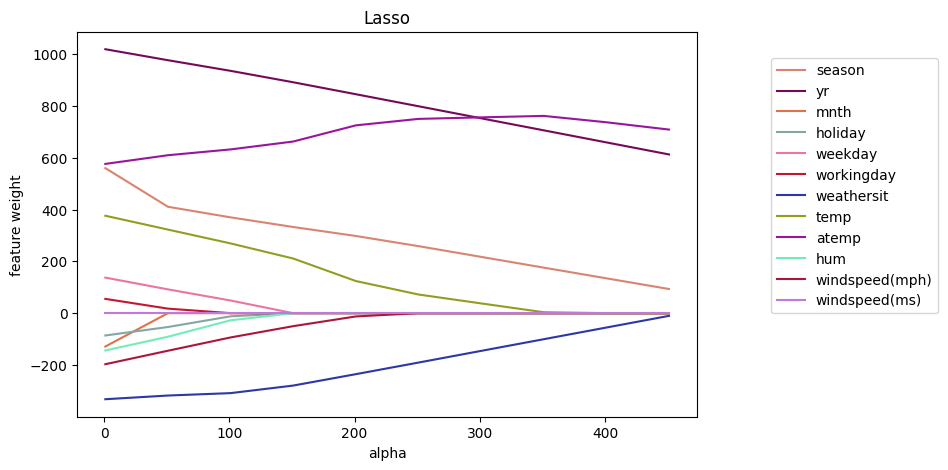

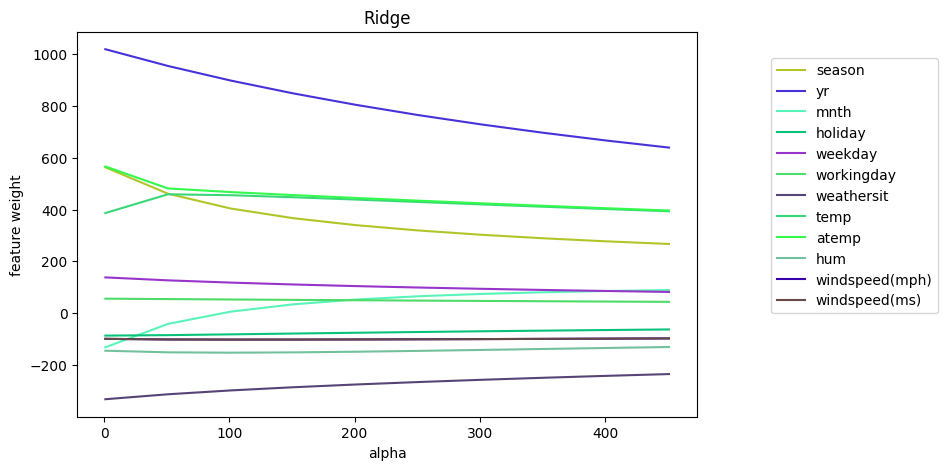

In [37]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

**Відповіді:**
1. Lasso
2. зійдуться в 1 точці = 0, бо функція мінімізує коефіцієнти, а не рівняння в цілому
3. Lasso - так, Ridge вирівнює їх
4. lasso щоб потім їх відкинути

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [38]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)
    x = data[xlabel]
    y = data[ylabel]

    plt.plot(x, y)

    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

choosen alpha is 6



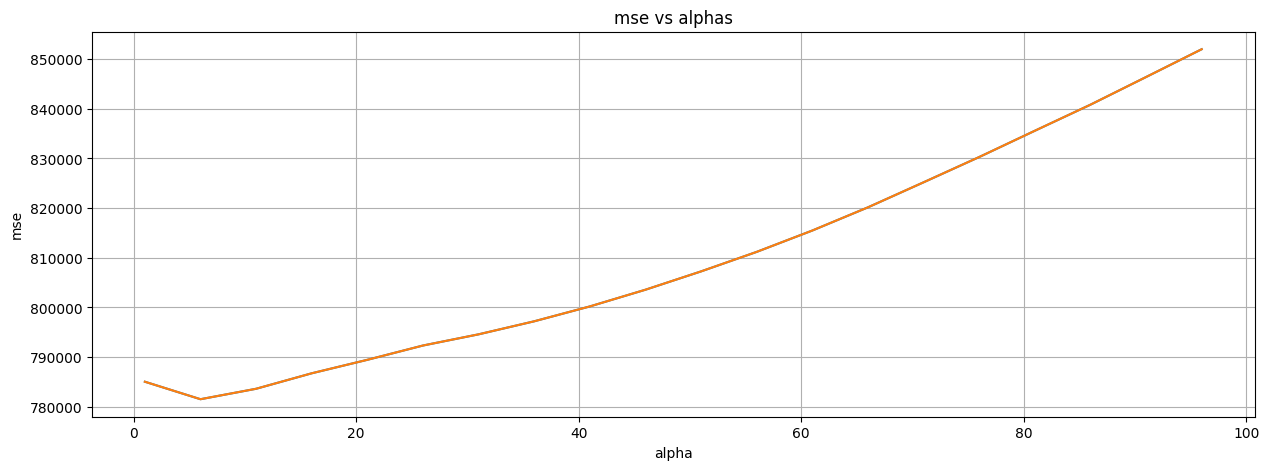

In [39]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas,cv=3).fit(X,y)

mse_alphas = pd.DataFrame({
             'mse': regressor.mse_path_.mean(axis=1),
             'alpha': regressor.alphas_})

print(f"choosen alpha is {regressor.alpha_}\n")
create_plot(mse_alphas,"mse vs alphas", "alpha","mse")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [40]:
mse_path = regressor.mse_path_
alphas_array  = regressor.alphas_
min_index = np.argmin(mse_path, axis=0)

for col in range(mse_path.shape[1]):
    min_ind = min_index[col]
    print(f"values: {mse_path[min_ind,col]}, alpha: {alphas_array[col]}")

values: 733725.7604052249, alpha: 96
values: 799433.1673691692, alpha: 91
values: 796979.8955193626, alpha: 86


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

[('season', 532.0189828413535), ('yr', 1015.0602226430595), ('mnth', -100.03952614356629), ('holiday', -83.29395987529904), ('weekday', 132.50446549095795), ('workingday', 51.557085614073735), ('weathersit', -330.5598567399817), ('temp', 370.67985503003405), ('atemp', 581.396931065498), ('hum', -140.00740550068844), ('windspeed(mph)', -191.77140847135036), ('windspeed(ms)', -2.6854702314758792e-08)]


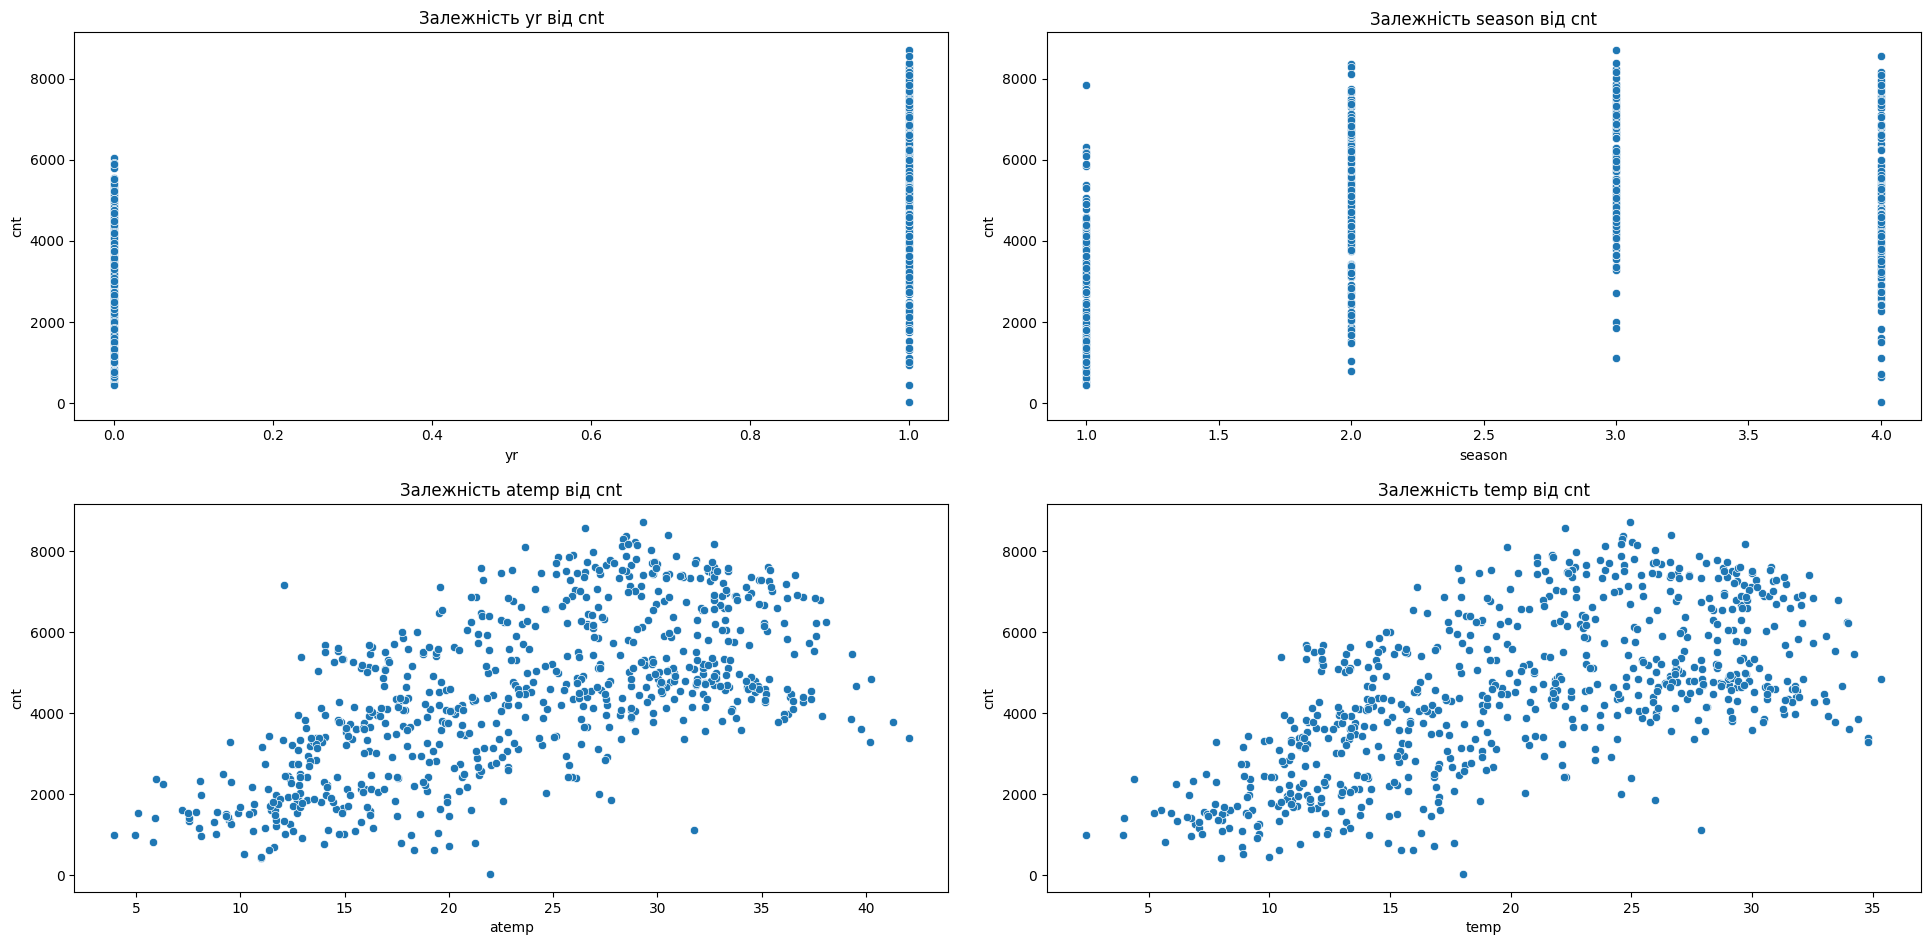

In [55]:
coefs = regressor.coef_
columns = df.columns
data = list(zip(columns,coefs))
print(data)
# highest is: yr, season, atemp,temp

attributes = ['yr','season','atemp','temp']
fig, sub_plot = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attribute in enumerate(attributes):
    row, col = divmod(i, 2)
    sns.scatterplot(ax=sub_plot[row, col], x=df[attribute], y=y)
    sub_plot[row, col].set_title(f'Залежність {attribute} від cnt')
plt.show()
# Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками? - так
# Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди? з точки зору даних - так, але
# для году - логічним є зростання на другий рік, чи буде далі - ми не знаємо.
# для сезону - це періодичне зростання. коли тепліше температура, тоді і вище
# температура - до певної межі точно буде зростати, але далі, при досягнення граничного рівня комфорту буде падіння (що зараз по даним не видно)


#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

[('season', 532), ('yr', 1015), ('mnth', -100), ('holiday', -83), ('weekday', 132), ('workingday', 51), ('weathersit', -330), ('temp', 370), ('atemp', 581), ('hum', -140), ('windspeed(mph)', -191), ('windspeed(ms)', 0)]


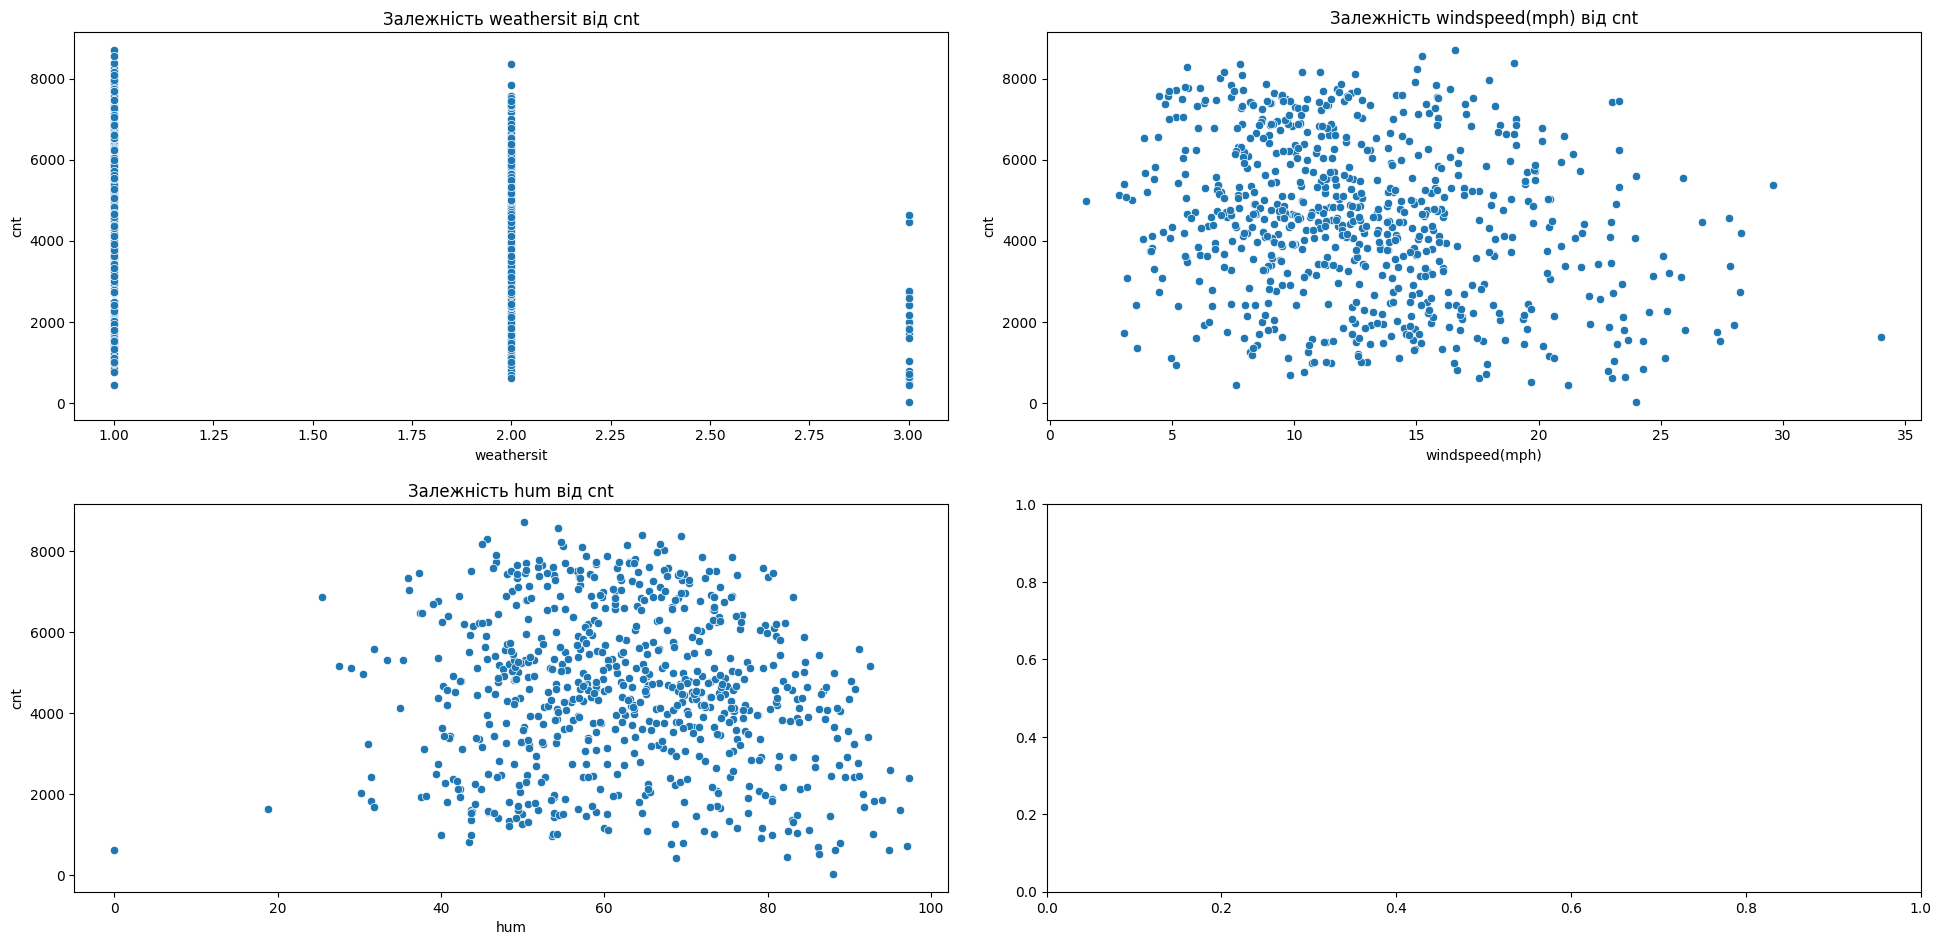

In [57]:
coefs = regressor.coef_.astype(int)
columns = df.columns
data = list(zip(columns,coefs))
print(data)
# lowest is: 'weathersit','windspeed(mph)','hum'

attributes = ['weathersit','windspeed(mph)','hum']
fig, sub_plot = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.tight_layout(pad=4.0)

for i, attribute in enumerate(attributes):
    row, col = divmod(i, 2)
    sns.scatterplot(ax=sub_plot[row, col], x=df[attribute], y=y)
    sub_plot[row, col].set_title(f'Залежність {attribute} від cnt')
plt.show()
# Чи видно лінійну залежність, що зменшується? - 'weathersit' - так, бо 4-найгірша погода. windspeed(mph) - так, 'hum' - зменшується після 80%, що логічно. так при зростанні від 80 до 100 зменшується.
# Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди? так


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

[('season', 532.0189828413535), ('yr', 1015.0602226430595), ('mnth', -100.03952614356629), ('holiday', -83.29395987529904), ('weekday', 132.50446549095795), ('workingday', 51.557085614073735), ('weathersit', -330.5598567399817), ('temp', 370.67985503003405), ('atemp', 581.396931065498), ('hum', -140.00740550068844), ('windspeed(mph)', -191.77140847135036), ('windspeed(ms)', -2.6854702314758792e-08)]


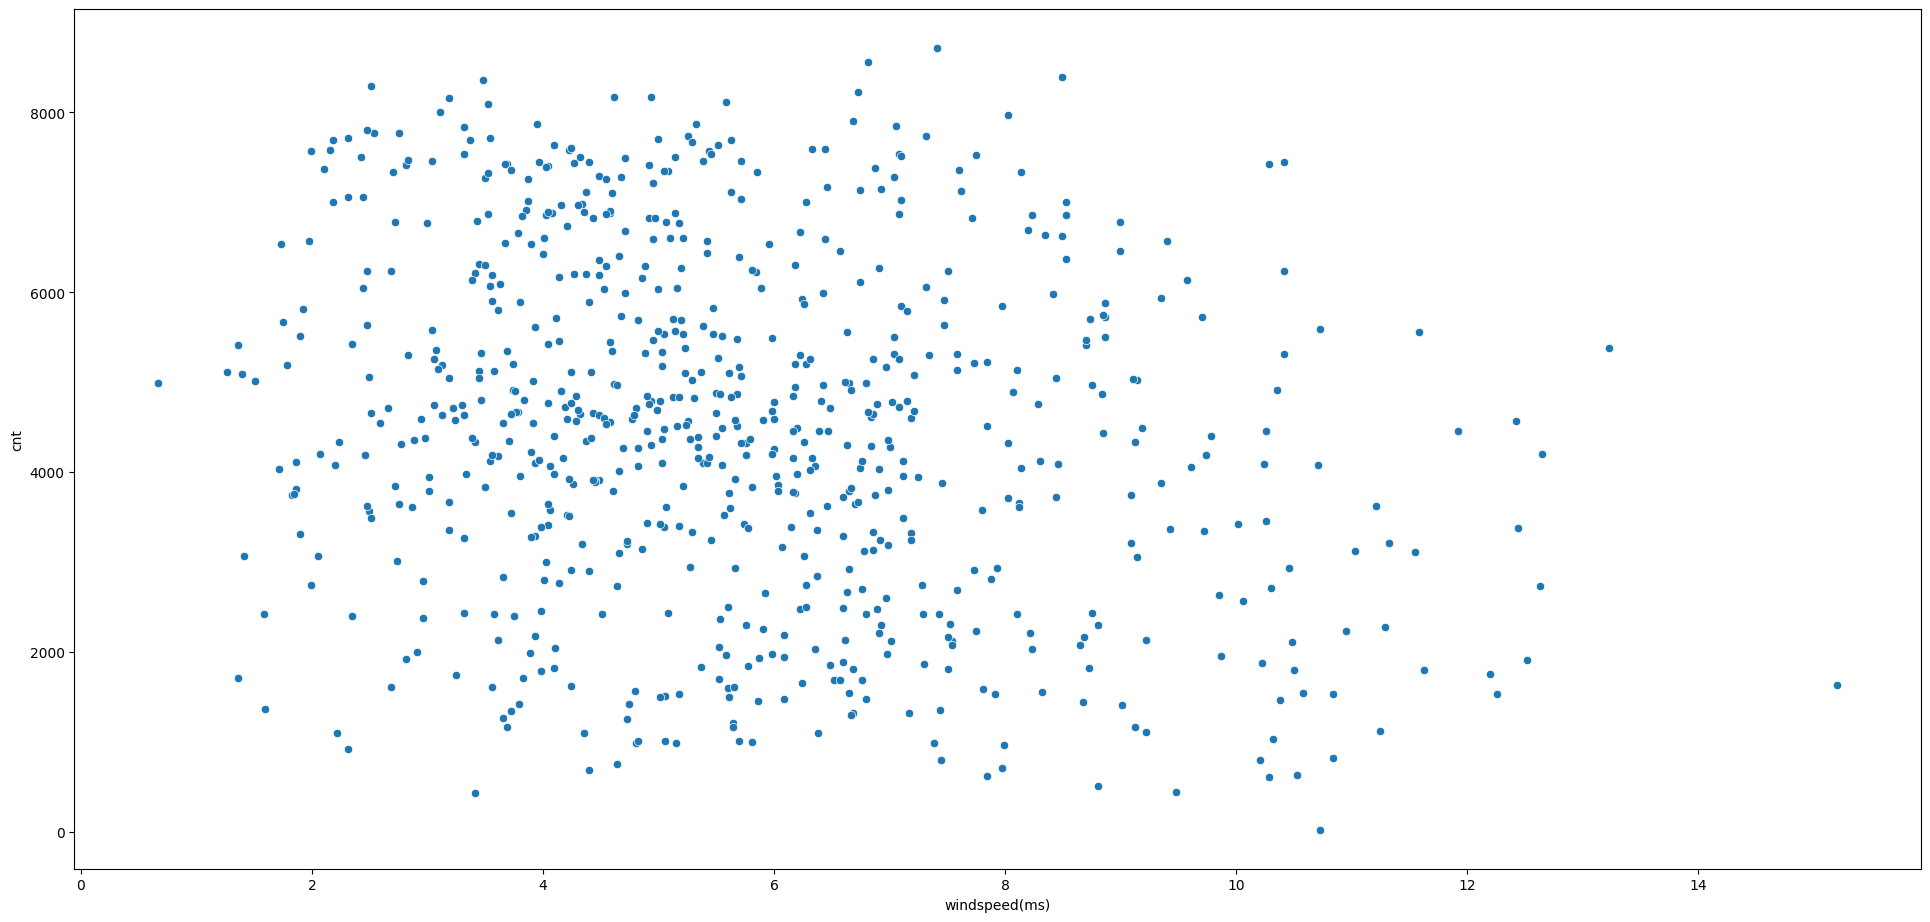

In [62]:
coefs = regressor.coef_
columns = df.columns
data = list(zip(columns,coefs))
print(data)
# highest is: yr, season, atemp,temp

attributes = ['windspeed(ms)']
fig, sub_plot = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.tight_layout(pad=4.0)
sns.scatterplot(x=df['windspeed(ms)'], y=y)
plt.show()
# Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? - враховуэчи коеф. - так
# Чи правда, що вони ніяк не впливають на попит на велосипеди? - впливає швидкість вітру, а це дубль колонок, тому саме ця колонка невпливає

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.